### Abstract

In this blog post, we will be replicating a study published by Obermeyer et al. in 2019. They found evidence of racial bias in one widely used algorithm. We will visualize how Black patients are often not flagged for extra care even when their white counterparts with the same health conditions are flagged. We will see that Black patients are labeled as lower risk because healthcare costs are used as a proxy for healthcare needs, and less money is spent on Black patients, making it seem like they have less need for extra care. We will quantify this result using a linear regression, and discuss which  ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍statistical ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍discrimination ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍criteria describes the bias we found in this algorithm. 

In [16]:
#| include: false

# Imports
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler


First, we'll read in and take a look at the dataset. 

In [17]:
# Read in the data
url = "https://gitlab.com/labsysmed/dissecting-bias/-/raw/master/data/data_new.csv?inline=false"
df = pd.read_csv(url)

In [18]:
#| echo: false
df.head()

,risk_score_t,program_enrolled_t,cost_t,cost_avoidable_t,bps_mean_t,ghba1c_mean_t,hct_mean_t,cre_mean_t,ldl_mean_t,race,...,trig_min-high_tm1,trig_min-normal_tm1,trig_mean-low_tm1,trig_mean-high_tm1,trig_mean-normal_tm1,trig_max-low_tm1,trig_max-high_tm1,trig_max-normal_tm1,gagne_sum_tm1,gagne_sum_t
0,1.987430,0,1200.0,0.0,NaN,5.4,NaN,1.110000,194.0,white,...,0,0,0,0,0,0,0,0,0,0
1,7.677934,0,2600.0,0.0,119.0,5.5,40.4,0.860000,93.0,white,...,0,1,0,0,1,0,0,1,4,3
2,0.407678,0,500.0,0.0,NaN,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,0,0,0,0
3,0.798369,0,1300.0,0.0,117.0,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,0,0,0,0
4,17.513165,0,1100.0,0.0,116.0,NaN,34.1,1.303333,53.0,white,...,0,0,0,0,0,0,0,0,1,1


We will be particularly focused on these columns: 
- risk_score_t ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍is ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍algorithm’s ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍risk ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍score ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍assigned ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍to ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍a ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍given ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍patient.
- cost_t ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍is ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍patient’s ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍medical ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍costs ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍in ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍study ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍period.
- race ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍is ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍patient’s ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍self-reported ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍race. ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍The ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍authors ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍filtered ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍data ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍to ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍include ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍only ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍white ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍and ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍black ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍patients.
- gagne_sum_t ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍is ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍total ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍number ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍of ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍chronic ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍illnesses ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍presented ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍by ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍patient ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍during ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍study ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍period.


### Reproducing Fig. 1

First, we'll look at some visualizations to get an understanding of our dataset. The first plot we will reproduce from the paper will look at risk score percentiles against mean number of active chronic conditions within each percentile. To make this plot, we'll start by calculating the percentiles for the risk scores. 

In [19]:
# Calculate risk score percentiles
df["risk_percentile"] = pd.qcut(df["risk_score_t"], 100, labels=False)

Next, we'll create a subplot for males and females to further split the data. To plot the risk scores and number of chronic conditions, we will iterate through each race in the dataset (just white and black) and take the mean number of chronic conditions for each risk score percentile. We will use different color and marker for each race, blue circles for black patients and green x's for white patients. 

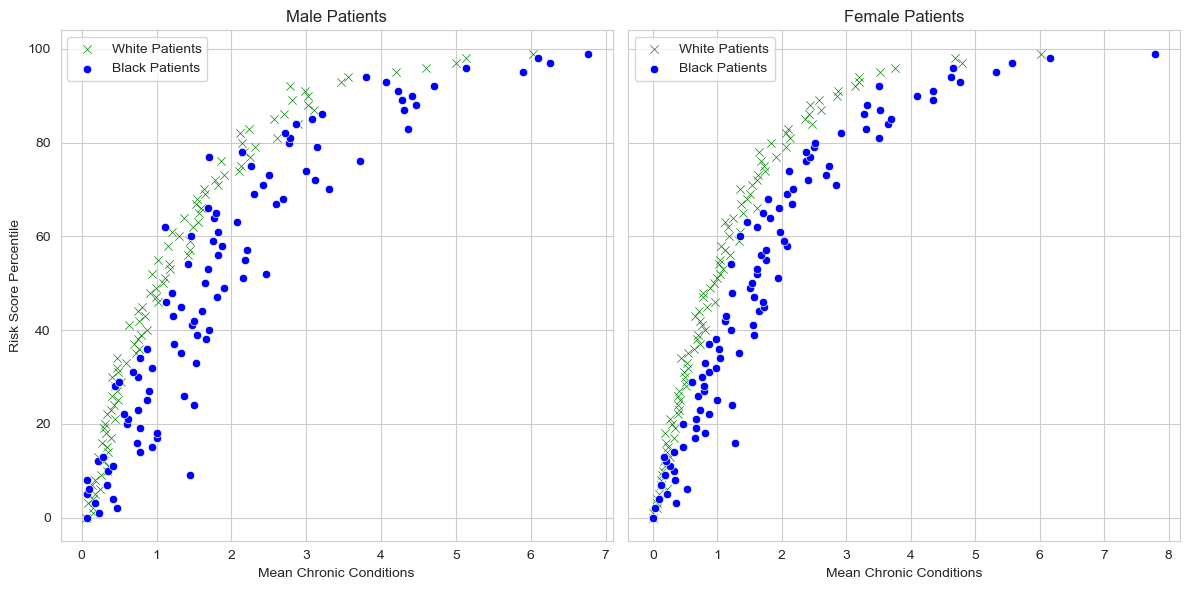

In [20]:
#| code-fold: true
#| code-summary: "Plotting code for risk score vs. number chronic conditions"
# Define markers for race on our plots
markers = {"white": "x", "black": "o"}
colors = {"white": "green", "black": "blue"}

sns.set_style("whitegrid")

# Create subplots for male (0) and female (1) patients
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

for i, female in enumerate([0, 1]):  # 0 = Male, 1 = Female
    ax = axes[i]
    # Iterate through the races in the df (black, white)
    for race in df["race"].unique():
        subset = df[(df["dem_female"] == female) & (df["race"] == race)]
        grouped = subset.groupby("risk_percentile")["gagne_sum_t"].mean().reset_index()
        sns.scatterplot(
            data=grouped, 
            x="gagne_sum_t", 
            y="risk_percentile", 
            marker=markers[race], 
            color = colors[race],
            label=f"{race.capitalize()} Patients", 
            ax=ax
        )
    ax.set_title(f"{'Female' if female == 1 else 'Male'} Patients")
    ax.set_xlabel("Mean Chronic Conditions")
    if i == 0:
        ax.set_ylabel("Risk Score Percentile")
    ax.legend()

plt.tight_layout()
plt.show()

Let's take a look at this plot to understand what might happen in this scenario: Patient A is black and Patient B is white and both patients have the same chronic illnesses. We can see from the plot that across both genders, it seems that Patient A and Patient B are not equally likely to be referred to the high-risk care management program. The blue points, which represent black patients, consistently have lower risk scores than green points that have at the same number of chronic illnesses. This would make it less likely for these black patients to be referred to a high-risk care management program because they are being scored as lower risk than white patients with the same illnesses. 

### Reproducing Fig. 3

Now, we'll reproduce another figure from the paper that should give us some more insight into why Black patients are being given lower risk scores than white patients with the same number of chronic conditions. First, we'll group across risk percentile and race to take the mean total medical expenditure  for each race at each risk percentile. Then, we'll group by number of chronic conditions and race so that we can take the mean total medical expenditure  for each race at each number of chronic conditions. 

In [21]:
risk_grouped = df.groupby(["risk_percentile", "race"])["cost_t"].mean().reset_index()
chronic_illness_grouped = df.groupby(["gagne_sum_t", "race"])["cost_t"].mean().reset_index()

Next, we'll make two subplots -- one that plots total medical expenditure by risk score percentile and one that plots total medical expenditure by number of chronic conditions. Again, we will use blue circles for black patients and green x's for white patients. 

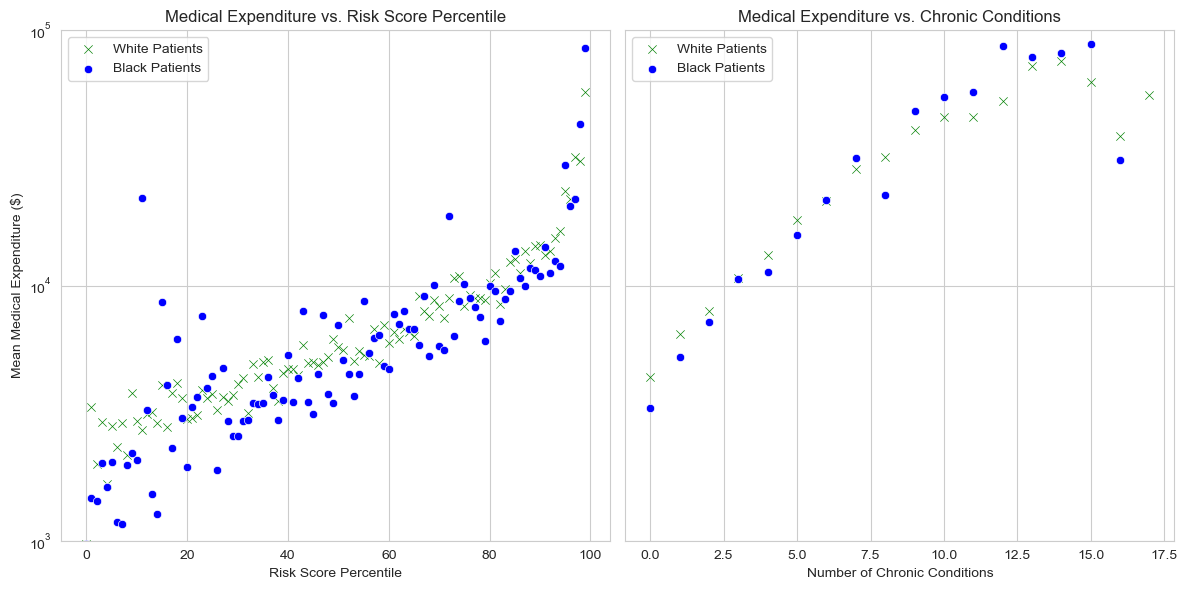

In [22]:
#| code-fold: true
#| code-summary: "Plotting code for medical expenditure vs. number chronic conditions and risk score"
# Create the figure with two panels
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Left panel: Mean expenditure vs. Risk Score Percentile
for race in df["race"].unique():
    subset = risk_grouped[risk_grouped["race"] == race]
    sns.scatterplot(
        data=subset,
        x="risk_percentile",
        y="cost_t",
        marker=markers[race],  
        color=colors[race],  
        label=f"{race.capitalize()} Patients",
        ax=axes[0]
    )

axes[0].set_title("Medical Expenditure vs. Risk Score Percentile")
axes[0].set_xlabel("Risk Score Percentile")
axes[0].set_ylabel("Mean Medical Expenditure ($)")
axes[0].set_ylim(1000, 10000)
axes[0].legend()
axes[0].set_yscale("log")

# Right panel: Medical Expenditure vs. Number of Chronic Conditions
for race in df["race"].unique():
    subset = chronic_illness_grouped[chronic_illness_grouped["race"] == race]
    sns.scatterplot(
        data=subset,
        x="gagne_sum_t",
        y="cost_t",
        marker=markers[race],  
        color=colors[race],  
        label=f"{race.capitalize()} Patients",
        ax=axes[1]
    )

axes[1].set_title("Medical Expenditure vs. Chronic Conditions")
axes[1].set_xlabel("Number of Chronic Conditions")
axes[1].set_ylabel("")
axes[1].set_ylim(1000, 100000)
axes[1].legend()
axes[1].set_yscale("log")

plt.tight_layout()
plt.show()

In this plot, we can get an understanding of how total medical expenditures are correlated with risk score and the number of chronic illnesses. It seems from the left panel that there is more variation in the mean medical expenditures for black patients by risk score than there is for white patients. Although we see many blue points (black patients) below green points with the same risk score, we also see blue points above green points with the same risk score. There is an interesting trend in the right panel -- it appears that white patients tend to have more medical expenditures than blank patients with the same number of chronic conditions when the number of conditions is less than 5, but as the number of conditions increases, black patients tend to have more medical expenditures than white patients with the same number of conditions. Considering that the vast majority of patients in this dataset have fewer than 5 chronic conditions, this dataset seems to show black patients, on average, having fewer medical expenditures than white patients with the same number of chronic conditions. 

### Modeling Cost Disparity

Now that we've gotten an understanding of the dataset and what's going on with bias here, let's make a model so that we can quantify it more accurately.We'll start with prepping the data. 

#### Data Prep

In [23]:
#| echo: false
print("Percentage of patients in DF with 5 or fewer chronic conditions:",round(len(df[df["gagne_sum_t"] <= 5])/len(df),2),"%")

Percentage of patients in DF with 5 or fewer chronic conditions: 0.96 %


Given that the vast majority of people in the dataset have fewer than 5 chronic conditions, I think it makes sense to just focus on these people in our analysis. We will take the log of the medical expenditures because they have a large range. 

In [24]:
# Take the log of the cost column (also remove costs that are 0)
df = df[df["cost_t"] > 0]
df["log_cost"] = np.log(df["cost_t"])

Next we'll encode the race dummy as an 0-1 variable, with 1 for black individuals and 0 for white individuals. 

In [25]:
# Encode the race variable as an integer 
df["race_dummy"] = (df["race"] == "black").astype(int)

Lastly, we will separate out our features (race and number of chronic conditions) from our target variable (total medical expenditure). 

In [26]:
# Separate predictor and target variables
X = df[["race_dummy", "gagne_sum_t"]]
y = df["log_cost"]

#### Modeling

We will fit a linear regression model with polynomial features in the number of active chronic conditions to account for the nonlinearity in the relationship between number of active chronic conditions that is apparent from the left hand panel in the above plot. We'll first define a function to add polynomial features to the dataset.

In [27]:
def add_polynomial_features(X, degree):
  X_ = X.copy()
  for j in range(1, degree):
    X_[f"poly_{j}"] = X_["gagne_sum_t"]**j
  return X_

Next, we will use this function to loop through polynomial features from $1$ to $11$ and regularization strengths $10^k$ from $k = -4, -3, ..., 3, 4$. 
The regularization strength is a parameter that describes how much the training process should prefer "simple" models with small values of the weights $w$ as opposed to a more complex model. At each degree-regularization combination, we'll train a model and compute the cross-validated mean squared error of the model. We will take the combination with the smallest mean squared error and use that degree-regularization combination to train the model we will use for our analysis. 

In [28]:
# Ranges of degrees and ks for regularization
degrees = range(1, 12)      
ks = range(-4, 4)    

results = []

for degree in degrees:
    # Add polynomial features to X_base (note: for degree == 1, nothing extra is added)
    X_poly = add_polynomial_features(X, degree)
    
    # Loop through each regularization strength
    for k in ks:
        alpha = 10**k
        # Create a Ridge regression model with the given alpha
        model = Ridge(alpha=alpha)
        
        # Use cross-validation to estimate the mean squared error.
        # Note: cross_val_score returns negative MSE when scoring is set to "neg_mean_squared_error"
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            scores = cross_val_score(model, X_poly, y, cv=5, scoring="neg_mean_squared_error")
        mse = -np.mean(scores)
            
        # Save the combination and results
        results.append({
            "degree": degree,
            "alpha": alpha,
            "cv_mse": mse
        })
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("cv_mse")

# Identify the best (lowest CV MSE) combination
best = round(results_df.iloc[0],2)

In [29]:
#| echo: false
print("\nBest combination:")
print(best)


Best combination:
degree    10.00
alpha      1.00
cv_mse     1.51
Name: 76, dtype: float64


So, we can see that our optimal parameter combination is $\alpha = 1$ with a degree of $10$. Next let's fit a model to the entire dataset using these parameters. 

In [30]:
# Fit a model on the entire dataset 
X_poly = add_polynomial_features(X, 10)

# Create a Ridge regression model with the alpha=1
model = Ridge(alpha=1)

# Fit the model on the entire dataset to extract coefficients
model.fit(X_poly, y)

# Find the coefficient corresponding to race_dummy
coef_index = list(X_poly.columns).index("race_dummy")
race_coef = model.coef_[coef_index]
exp_race_coef = np.exp(race_coef)

In [31]:
#| echo: false
print("\nBlack coefficient:", round(race_coef,2))


Black coefficient: -0.27


Based on these results, we can see that the coefficient associated with the Black individuals in the dataset is $w_b = -0.27$. We can calculate $e^{w_b} = e^{-0.27} = 0.76$. So, percentage of cost incurred by a Black patient in comparison to an equally sick white patient, is around 76%. This supports the argument that was made in the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍Obermeyer paper because it suggests that less money is spent on Black patients who have the same level of need as white patients. 

### Discussion

After replicating the study done in the Obermeyer paper, we can see that because less money is spent on Black patients' healthcare, they are often classified as lower risk than white patients who have the same chronic conditions. This has concerning implications, as it seems like this algorithm was making it harder for Black patients to access care than white patients, even if the Black patients are sicker than the white patients. 

In terms of the formal ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍statistical ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍discrimination ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍criteria ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍discussed in Chapter 3 of ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍ ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍Barocas, Hardt, and Narayanan, the separation criterion best describes the bias that Obermeyer et al. found in their paper. This is because separation would require that the risk score be conditionally independent of race given true health need. That is,  if two individuals have the same underlying health status, their risk scores should be statistically indistinguishable across racial groups. But, our results show that this isn't true when we use this algorithm. Our results showed that Black patients with the same chronic conditions as white patients are assigned lower risk scores because the algorithm uses healthcare expenditures as a proxy for health need. Even though the algorithm may be able to predict health care costs effectively, these effective predictions are not an accurate proxy for health need, which makes the algorithm violate the separation criterion. Even though the model may be accurate, it is not necessarily unbiased. 

I learned a lot from replicating this study. I think I went into it with an understanding of the importance of accuracy and equality in a model, but without considering the implications of the model. Even though this model may have been accurate, the context in which it was being applied made it so that it was biased against Black individuals. Using one feature as a proxy for another feature seems tricky, and requires a lot of auditing to ensure that it doesn't create bias. 

